# RNA family characterization

Application scenario: we want to characterize RNA family, identifying regions with their structural contexts that are characteristic of the family

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import logging
from eden.util import configure_logging
configure_logging(logging.getLogger(), verbosity=2)

given the RFAM id of a family we retrieve it from the RFAM online database
composing the correspondent URL

In [2]:
import os
import requests

def save(text, full_out_file_name):
    with open(full_out_file_name, 'w') as f:
        for line in text:
            f.write("%s\n" % line.encode('utf8').strip())

def rfam_uri(family_id):
    # retrieve the seed sequences from RFAM and save them to file
    uri = 'http://rfam.xfam.org/family/%s/alignment?acc=%s&format=fastau&download=0'%(family_id,family_id) 
    output_dir_path= 'RFAM'
    fname = family_id + '.fa'
    if not os.path.exists(output_dir_path):
        os.mkdir(output_dir_path)
    full_out_file_name = os.path.join(output_dir_path, fname)
    if not os.path.isfile(full_out_file_name):
        text = requests.get(uri).text.split('\n')
        save(text, full_out_file_name)
    return full_out_file_name

In [3]:
rfam_id = 'RF02275' #Hammerhead_HH9

In [4]:
rfam_id = 'RF00871' #microRNA mir-689

In [5]:
rfam_id = 'RF00380' #

In [6]:
rfam_id = 'RF00005' #tRNA

In [7]:
#parameters for visualization
opts={'size':14, 'vertex_border':False, 'vertex_size':200, 'font_size':9, 'vertex_alpha':0.6,
     'title_key':'sequence'}

from eden.util.display import draw_graph, serialize_graph
import itertools
def plot(graphs, num=3, file_name=None, opts=None):    
    graphs = itertools.islice(graphs,num)
    for i,graph in enumerate(graphs): 
        if file_name is not None:
            draw_graph(graph, file_name=file_name+str(i)+'.png', **opts)
        else:
            draw_graph(graph, **opts)

In [8]:
def pre_process(data):
    from eden.converter.fasta import fasta_to_sequence
    seqs = fasta_to_sequence(data)
    
    from eden.converter.rna.rnafold import rnafold_to_eden
    graphs = rnafold_to_eden(seqs)

    from eden.modifier.graph import vertex_attributes
    graphs = vertex_attributes.list_reweight(graphs, start_end_weight_list=[(-1,-1,0),(10,20,1), (30,40,2)])
    return graphs

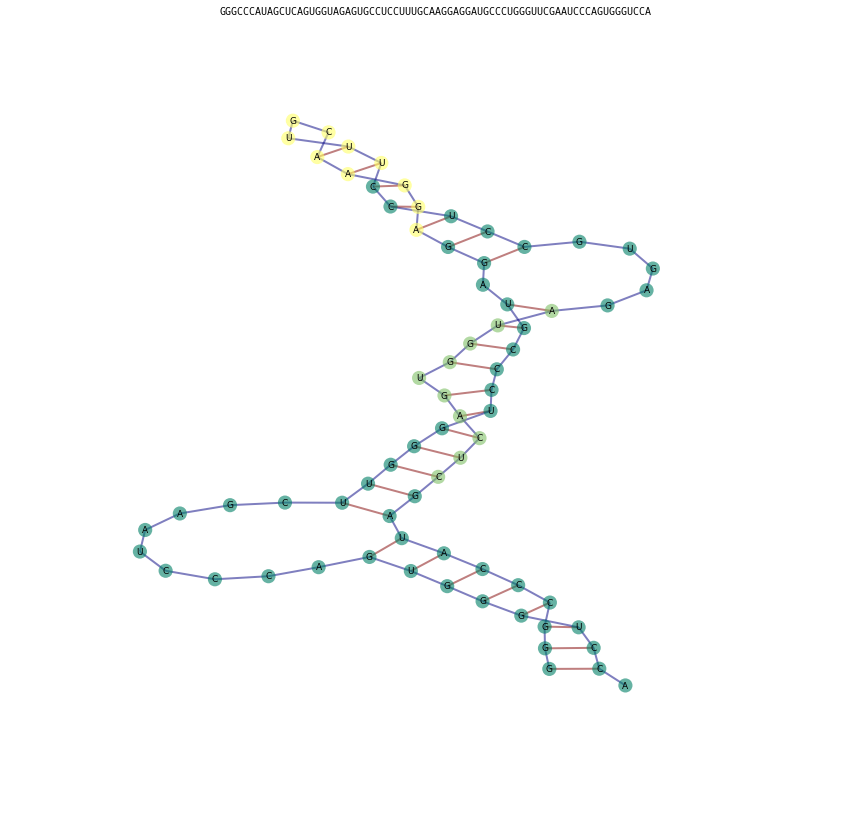

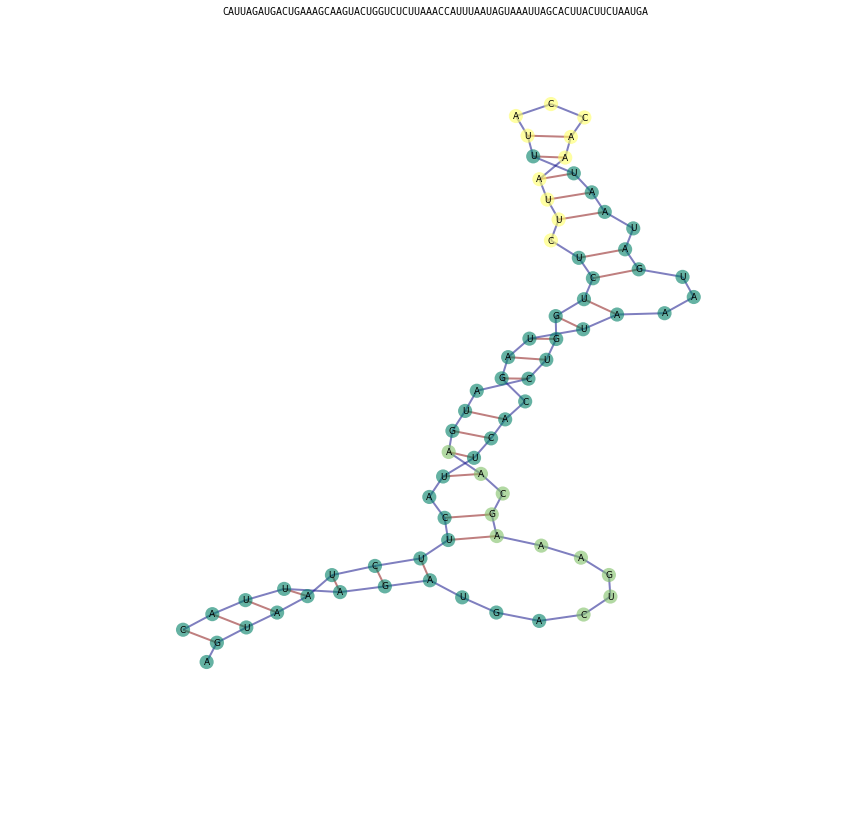

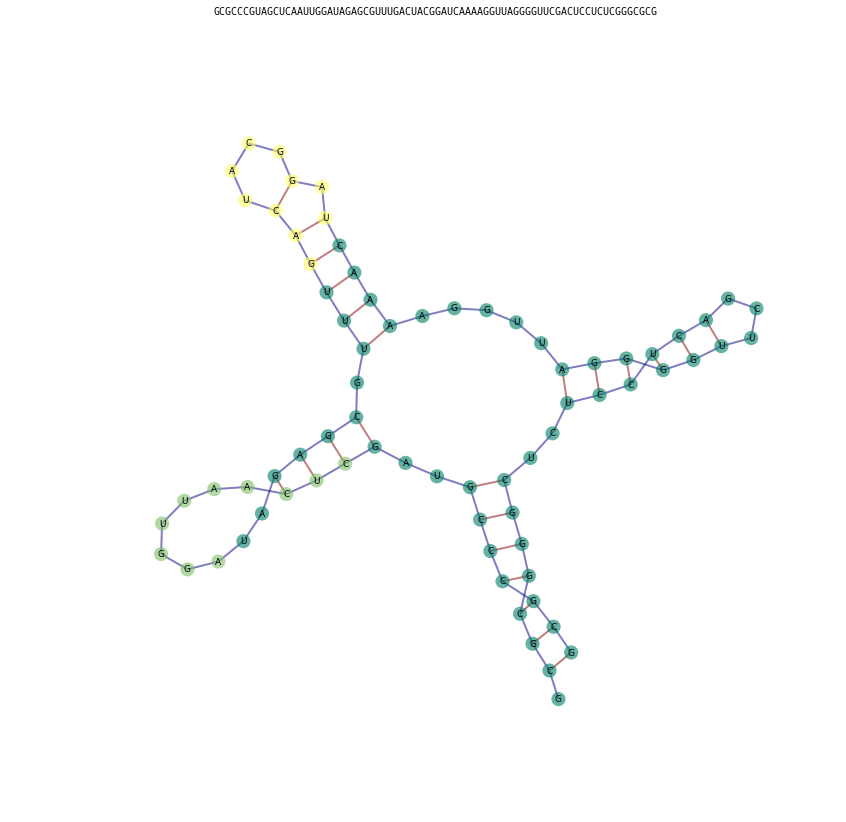

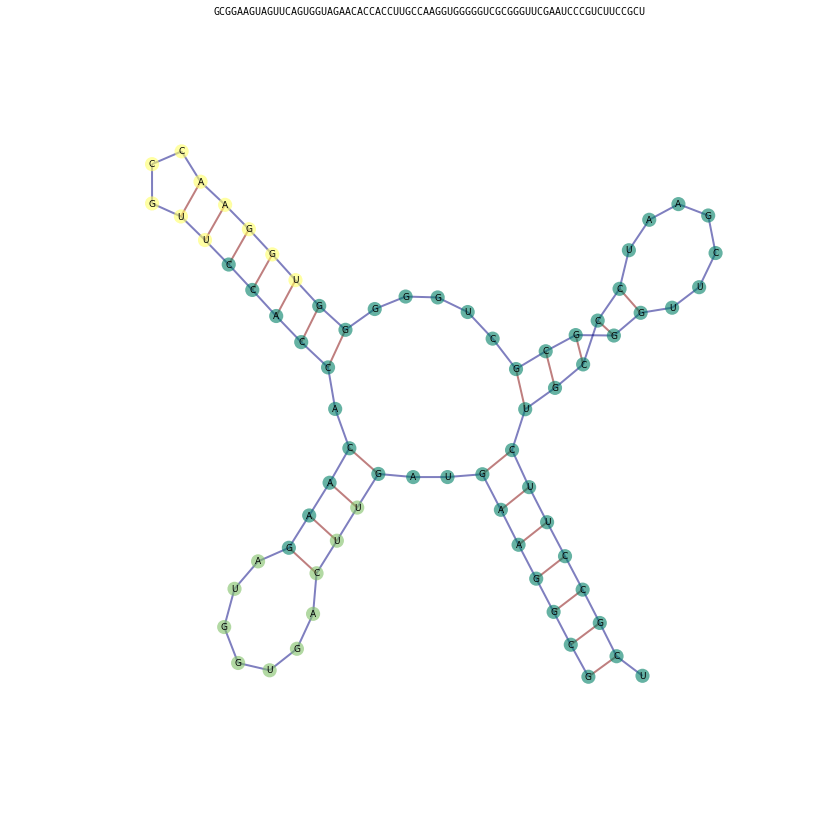

In [9]:
graphs = pre_process(rfam_uri(rfam_id))
my_opt=dict(opts)
my_opt.update({'vertex_color':'weight', 'colormap':'summer', 
               'edge_color':'_labels_', 'edge_label':None, 'prog':'neato'})
plot(graphs,num=4,opts=my_opt)

In [10]:
def pre_process(data):
    from GArDen.interfaces import convert, transform
    from GArDen.convert.sequence import FastaToPathGraph
    graphs=transform(data, program=FastaToPathGraph())
    from GArDen.transform.rna_structure import PathGraphToRNAPlfold
    parameters_priors = dict(window_size = 250,
                             max_bp_span = 150,
                             avg_bp_prob_cutoff = 0.01,
                             max_num_edges = 2,
                             no_lonely_bps=True,
                             nesting=True,
                             hard_threshold=0.5)
    graphs = transform(graphs, program=PathGraphToRNAPlfold(), parameters_priors=parameters_priors)
       
    from eden.modifier.graph import vertex_attributes 
    graphs = vertex_attributes.colorize(graphs, output_attribute = 'level', labels = ['A','U','C','G'])

    return graphs

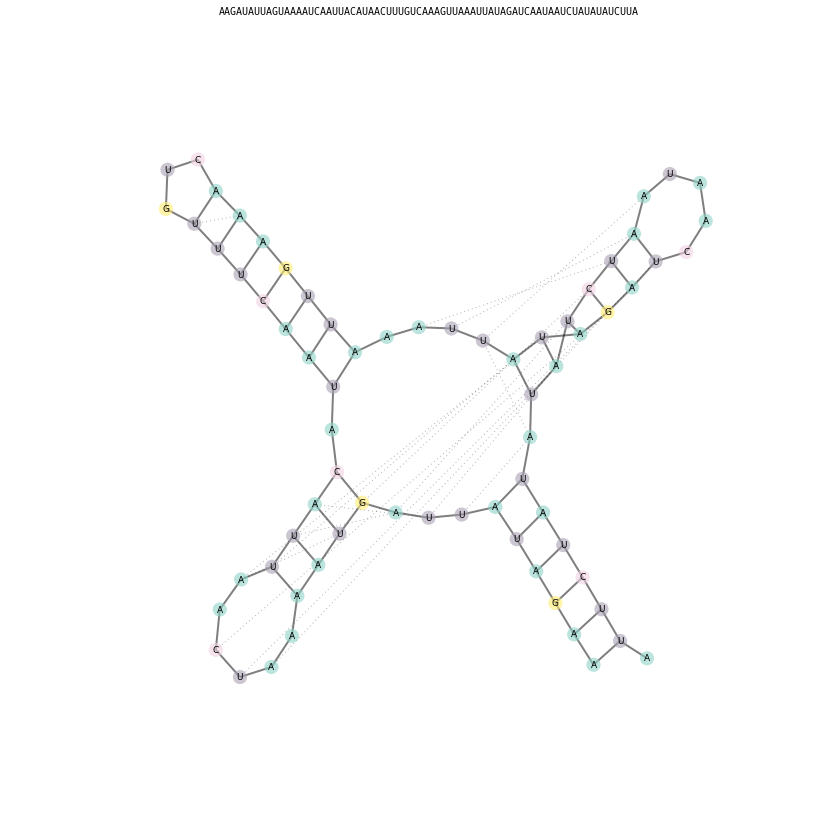

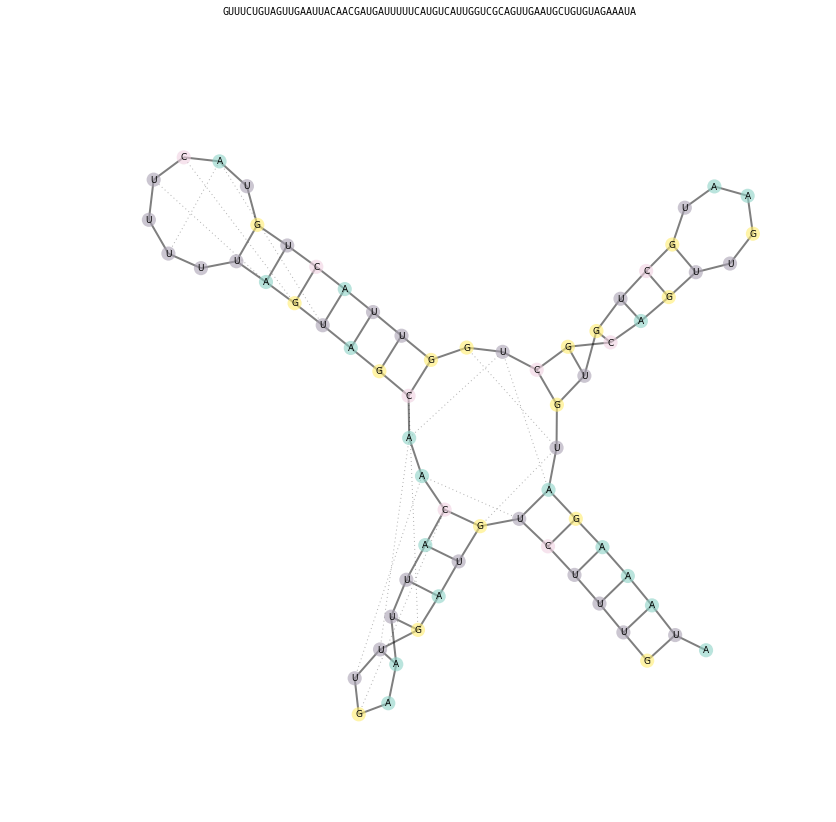

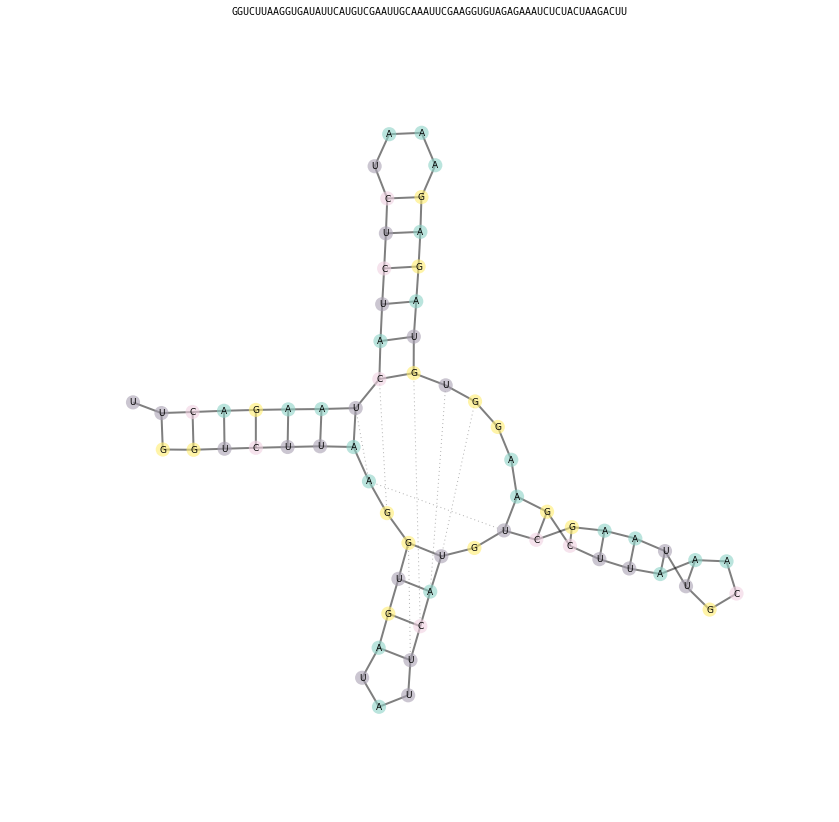

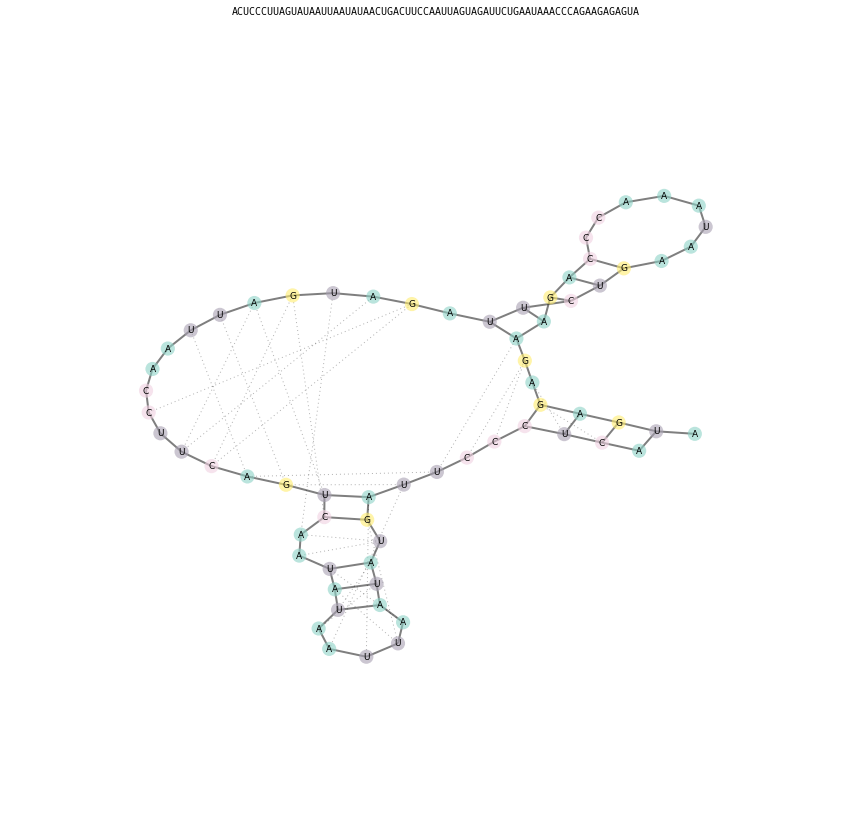

In [11]:
graphs = pre_process(rfam_uri(rfam_id))
my_opt=dict(opts)
my_opt.update({'vertex_color':'level', 'colormap':'Set3', 'edge_label':None, 'ignore_for_layout':'nesting'})
from itertools import islice
graphs=islice(graphs, 20,None)
plot(graphs,num=4, opts=my_opt)

In [12]:
def pre_process(data):
    from GArDen.interfaces import convert, transform, compose, decompose, partition
    from GArDen.convert.sequence import FastaToPathGraph
    graphs=transform(data, program=FastaToPathGraph())
    from GArDen.transform.rna_structure import PathGraphToRNAShapes
    parameters_priors = dict(shape_type=5, energy_range=35, max_num=3, output_type='disjoint_union')
    graphs = transform(graphs, program=PathGraphToRNAShapes(), parameters_priors=parameters_priors)
    return graphs

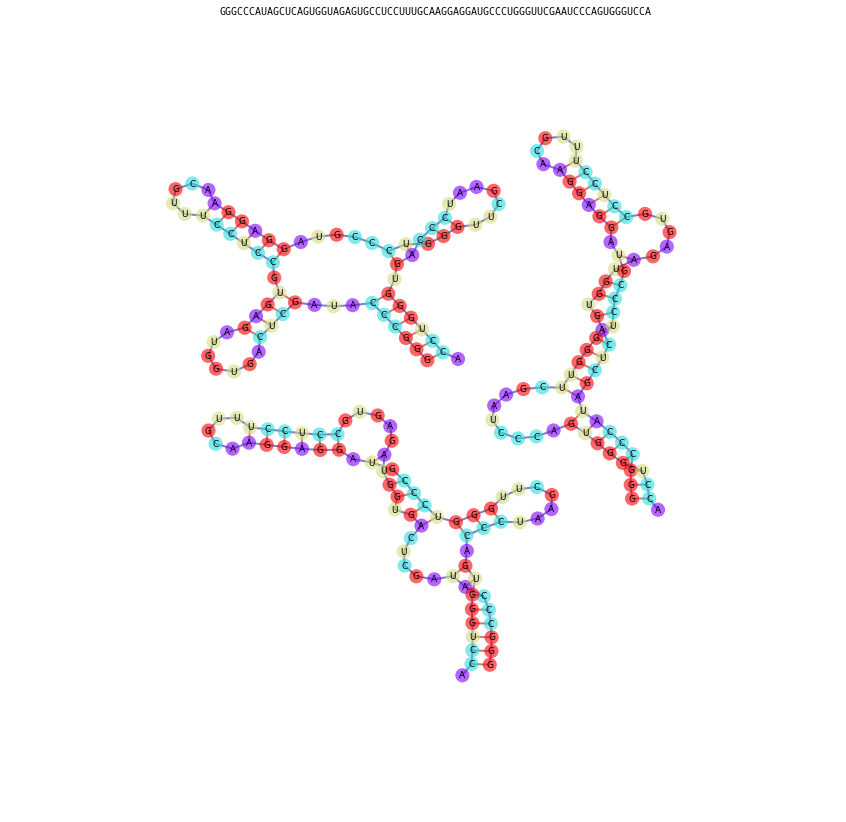

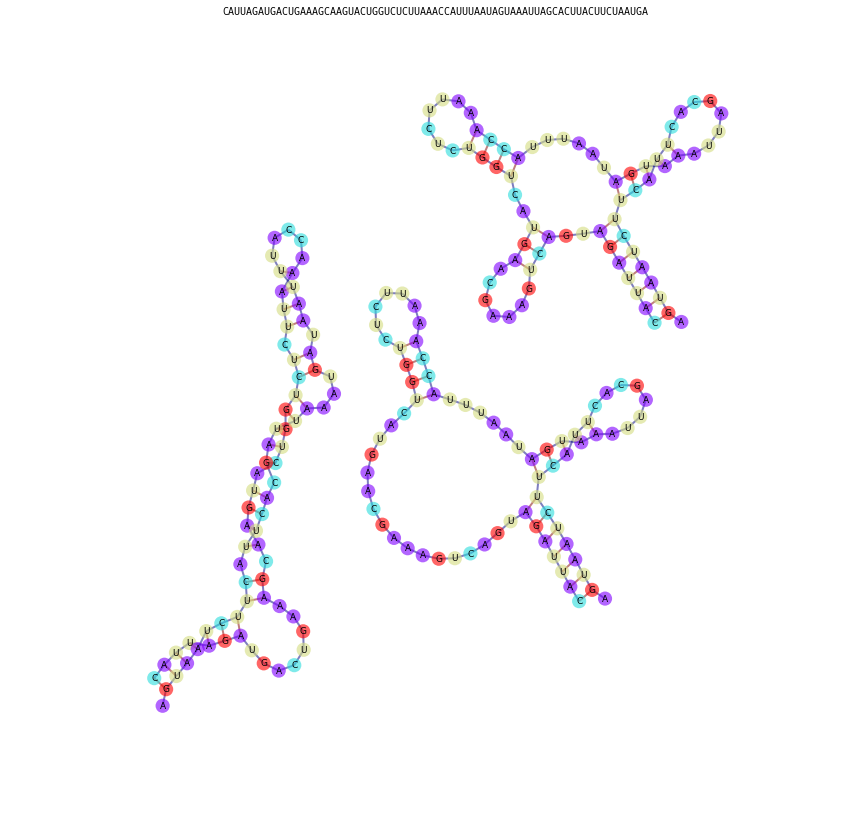

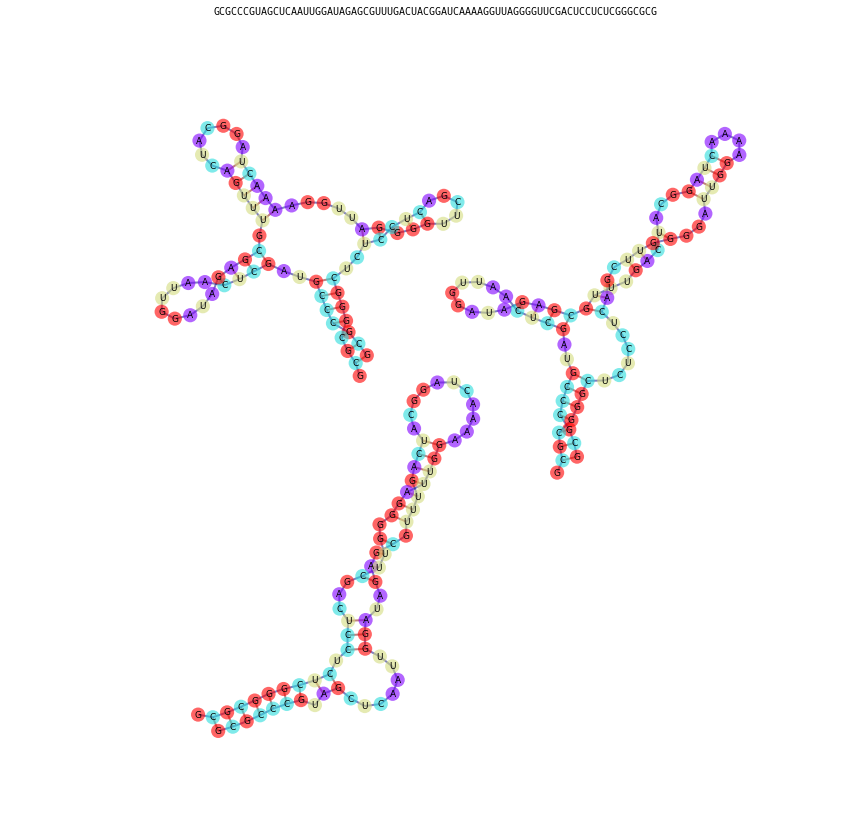

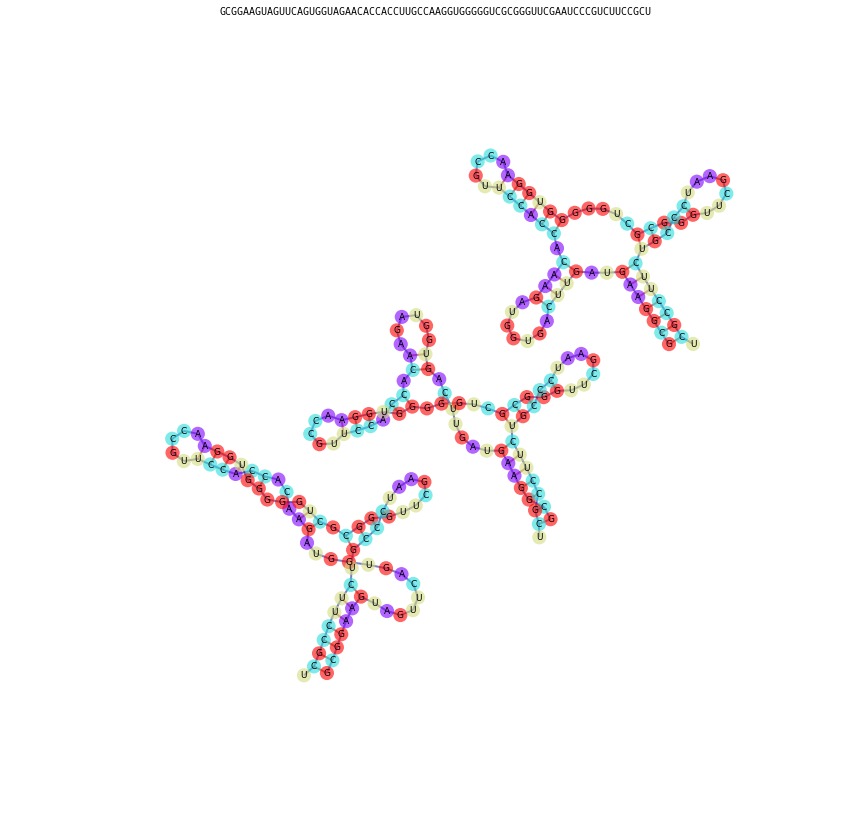

In [13]:
graphs = pre_process(rfam_uri(rfam_id))
my_opt=dict(opts)
my_opt.update({'vertex_color':'_label_', 'colormap':'rainbow', 'edge_color':'_labels_', 'edge_label':None})
plot(graphs, num=4, opts=my_opt)

# Plan
- annotate
- for each graph X and Y
- extract the vector attribute of each node
- materialize the matrix
- K = the pairwise linear kernel X,Y
- give it to needlemanwunsh as matrix
- get the traceback

- use sequence alignment to improve consensus folding  

In [14]:
import GArDen.interfaces as garden

def convert(rfam_id, program=None, parameters_priors=None):
    data = rfam_uri(rfam_id)
    from GArDen.convert.sequence import FastaToPathGraph
    seqs=garden.transform(data, program=FastaToPathGraph())
    graphs = garden.transform(seqs, program=program, parameters_priors=parameters_priors)
    return graphs

def extract_features(graph):
    from GArDen.transform.importance_annotation import AnnotateImportance
    graphs = garden.transform([graph], program=AnnotateImportance(program=None, relabel=True))
    graph = graphs.next()
    from scipy.sparse import vstack
    vec = vstack([graph.node[u]['features'] for u in graph.nodes()])
    seq = ''.join([graph.node[u]['label'] for u in graph.nodes()])
    return seq, vec

def align(graph_a, graph_b, gap_penalty=.001):
    seq_a, vec_a = extract_features(graph_a)
    seq_b, vec_b = extract_features(graph_b)

    from sklearn import metrics
    score_matrix=metrics.pairwise.pairwise_kernels(vec_a, vec_b, metric='linear')

    from eden.util.NeedlemanWunsh import needleman_wunsh, trace_back
    needleman_wunsh_matrix = needleman_wunsh(seq_a, seq_b, score_matrix, gap_penalty)
    alignment_a, alignment_b = trace_back(seq_a, seq_b, score_matrix, needleman_wunsh_matrix, gap_penalty)
    return alignment_a, alignment_b

def join_graphs_with_alignment(graph_a, graph_b, alignment_a, alignment_b):
    import networkx as nx
    union_graph = nx.disjoint_union(graph_a,graph_b)
    counter_u=0
    counter_v=len(graph_a)
    for u,v in zip(alignment_a, alignment_b):
        if u != '-' and v != '-':
            union_graph.add_edge(counter_u, counter_v,label='|',nesting=True)
        if u != '-':
            counter_u += 1
        if v != '-':
            counter_v += 1
    return union_graph

def join_graphs(graph_a, graph_b):
    alignment_a, alignment_b = align(graph_a, graph_b, gap_penalty=-1)
    union_graph = join_graphs_with_alignment(graph_a, graph_b, alignment_a, alignment_b)
    return union_graph, alignment_a, alignment_b


def print_alignment(alignment_a, alignment_b):
    connector = ''.join(['_' if a == b else ' ' for a,b in zip(alignment_a, alignment_b)])
    print connector
    print alignment_a
    print alignment_b
    
def txt_alignment_fasta(alignment_a, alignment_b):
    txt = ''
    txt += '>1\n'
    txt += alignment_a + '\n'
    txt += '>2\n'
    txt += alignment_b + '\n'
    return txt


def txt_alignment_clustal(alignment_a, alignment_b):
    txt = 'CLUSTALW\n\n'
    txt += '>1 '
    txt += alignment_a + '\n'
    txt += '>2 '
    txt += alignment_b + '\n'
    return txt

In [21]:
def fold_align(alignment_a, alignment_b):
    txt = txt_alignment_clustal(alignment_a, alignment_b)
    import subprocess as sp
    flags = '--noPS'
    cmd = 'echo "%s" | RNAalifold %s' % (txt, flags)
    out = sp.check_output(cmd, shell=True)
    text = out.strip().split('\n')
    consensus = text[0]
    struct = text[1].split(' ')[0]
    return consensus, struct

def make_graph(seq_info, seq_struct):
    from GArDen.convert.sequence import sequence_dotbracket_to_graph
    graph = sequence_dotbracket_to_graph(header='ID_1', seq_info=seq_info, seq_struct=seq_struct)
    return graph 

def draw_RNA(graph):
    from eden.util.graph_layout import KKEmbedder
    pos = KKEmbedder(n_iter=40, stop_eps=1).transform(graph)
    from eden.util.display import draw_graph
    draw_graph(graph, pos=pos,**my_opt)

def project(seq_alignment, seq_struct):
    struct=''
    seq=''
    for a, s in zip(seq_alignment, seq_struct):
        if a != '-':
            seq += a
            struct += s
    return seq, struct

---

In [16]:
from GArDen.transform.rna_structure import PathGraphToRNAPlfold
parameters_priors = dict(window_size = 250,
                                 max_bp_span = 150,
                                 avg_bp_prob_cutoff = 0.01,
                                 max_num_edges = 2,
                                 no_lonely_bps=True,
                                 nesting=True,
                                 hard_threshold=0.5)
graphs = convert(rfam_id, program=PathGraphToRNAPlfold(), parameters_priors=parameters_priors)

In [17]:
from GArDen.transform.rna_structure import PathGraphToRNAFold
graphs = convert(rfam_id, program=PathGraphToRNAFold())

In [18]:
my_opt.update({'vertex_color':'_label_', 'colormap':'Set3', 'edge_label':None, 'ignore_for_layout':'nesting','title_key':None})

  _  _ ___  _____  __  __  _  __ _  _  _  _ _           ____  _____   _
GUUAAUGUAGCUUAAUAACAAAGCAAAGCACUGAAAAUGCUUAGAUGGAUAAUUGUAUCC-CAUAAAC--A
ACUUUUAUAGGAUAAUAGUAAUCCAUUGGUCUUAGGAACCAAAAACCUUGGUGCAAAUCCAAAUAAAAGUA


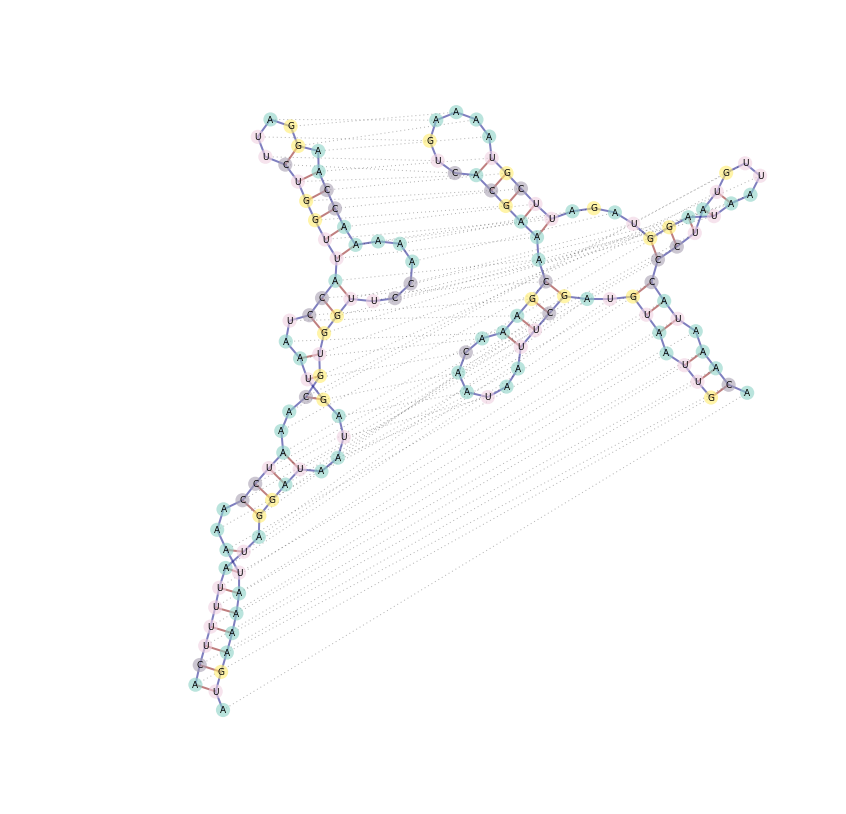

CPU times: user 2.35 s, sys: 111 ms, total: 2.46 s
Wall time: 2.93 s


In [27]:
%%time
instance_id=7
orig_graphs = list(islice(graphs,instance_id,instance_id+2))
graph_a, graph_b  = orig_graphs[0], orig_graphs[1]
union_graph, alignment_a, alignment_b = join_graphs(graph_a, graph_b)

print_alignment(alignment_a, alignment_b)
plot([union_graph], opts=my_opt)

GUUAAUGUAGCUUAAUAACAAAGCAAAGCACUGAAAAUGCUUAGAUGGAUAAUUGUAUCCCAUAAACA
.........((((.......)))).(((((.......)))))..........................
iteration 0/2720 score:4825.15 threshold:1.00
iteration 100/2720 score:650.37 threshold:1.00
iteration 200/2720 score:364.61 threshold:1.00
iteration 300/2720 score:209.00 threshold:1.00
iteration 400/2720 score:131.90 threshold:1.00
iteration 500/2720 score:107.20 threshold:1.00
iteration 600/2720 score:53.43 threshold:1.00
iteration 700/2720 score:32.63 threshold:1.00
iteration 800/2720 score:20.87 threshold:1.00
iteration 900/2720 score:14.68 threshold:1.00
iteration 1000/2720 score:8.58 threshold:1.00
iteration 1100/2720 score:8.42 threshold:1.00
iteration 1200/2720 score:7.04 threshold:1.00
iteration 1300/2720 score:4.91 threshold:1.00
iteration 1400/2720 score:5.56 threshold:1.00
iteration 1500/2720 score:5.19 threshold:1.00
iteration 1600/2720 score:6.19 threshold:1.00
iteration 1700/2720 score:4.14 threshold:1.00
iteration 1800/2720 score:3.6

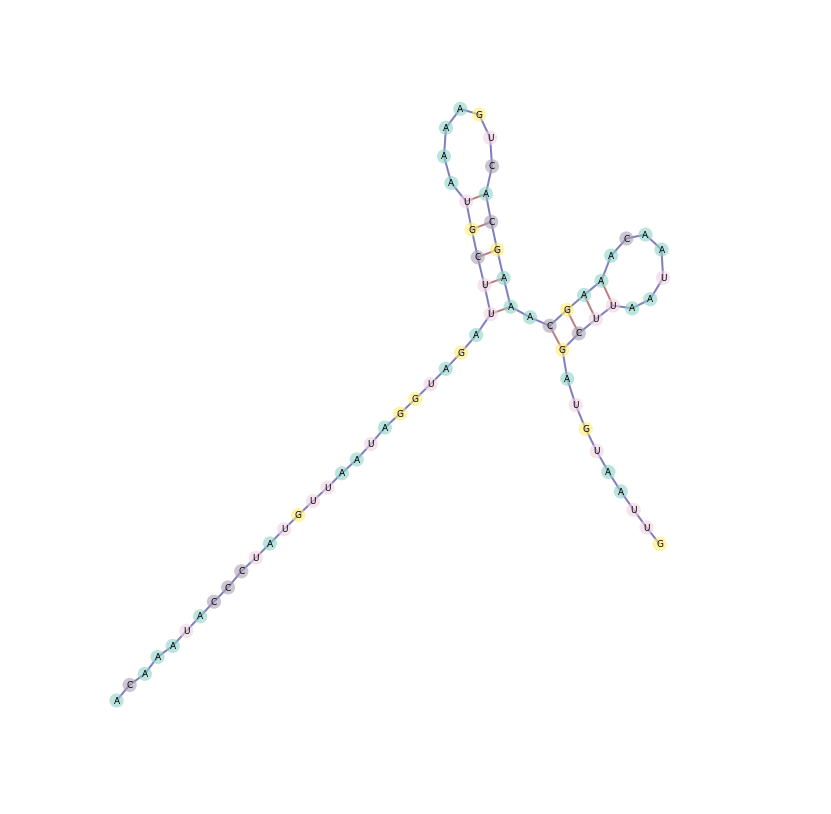

ACUUUUAUAGGAUAAUAGUAAUCCAUUGGUCUUAGGAACCAAAAACCUUGGUGCAAAUCCAAAUAAAAGUA
.........((((.......)))).(((((.......))))).............................
iteration 0/2840 score:5456.21 threshold:1.00
iteration 100/2840 score:779.92 threshold:1.00
iteration 200/2840 score:431.34 threshold:1.00
iteration 300/2840 score:372.57 threshold:1.00
iteration 400/2840 score:172.50 threshold:1.00
iteration 500/2840 score:131.60 threshold:1.00
iteration 600/2840 score:98.90 threshold:1.00
iteration 700/2840 score:56.21 threshold:1.00
iteration 800/2840 score:37.18 threshold:1.00
iteration 900/2840 score:21.97 threshold:1.00
iteration 1000/2840 score:14.46 threshold:1.00
iteration 1100/2840 score:10.96 threshold:1.00
iteration 1200/2840 score:9.86 threshold:1.00
iteration 1300/2840 score:8.00 threshold:1.00
iteration 1400/2840 score:7.13 threshold:1.00
iteration 1500/2840 score:6.24 threshold:1.00
iteration 1600/2840 score:7.18 threshold:1.00
iteration 1700/2840 score:6.36 threshold:1.00
iteration 1800/2840 s

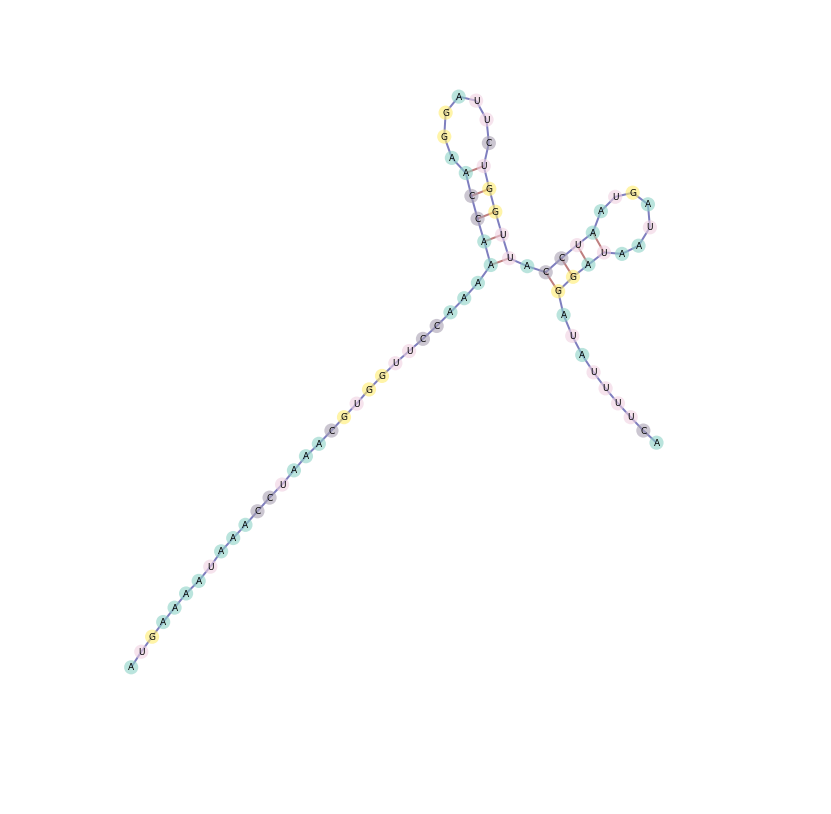

iteration 0/2840 score:5456.21 threshold:1.00
iteration 100/2840 score:779.92 threshold:1.00
iteration 200/2840 score:431.34 threshold:1.00
iteration 300/2840 score:372.57 threshold:1.00
iteration 400/2840 score:172.50 threshold:1.00
iteration 500/2840 score:131.60 threshold:1.00
iteration 600/2840 score:98.90 threshold:1.00
iteration 700/2840 score:56.21 threshold:1.00
iteration 800/2840 score:37.18 threshold:1.00
iteration 900/2840 score:21.97 threshold:1.00
iteration 1000/2840 score:14.46 threshold:1.00
iteration 1100/2840 score:10.96 threshold:1.00
iteration 1200/2840 score:9.86 threshold:1.00
iteration 1300/2840 score:8.00 threshold:1.00
iteration 1400/2840 score:7.13 threshold:1.00
iteration 1500/2840 score:6.24 threshold:1.00
iteration 1600/2840 score:7.18 threshold:1.00
iteration 1700/2840 score:6.36 threshold:1.00
iteration 1800/2840 score:4.73 threshold:1.00
iteration 1900/2840 score:4.36 threshold:1.00
iteration 2000/2840 score:3.52 threshold:1.00
iteration 2100/2840 score:5

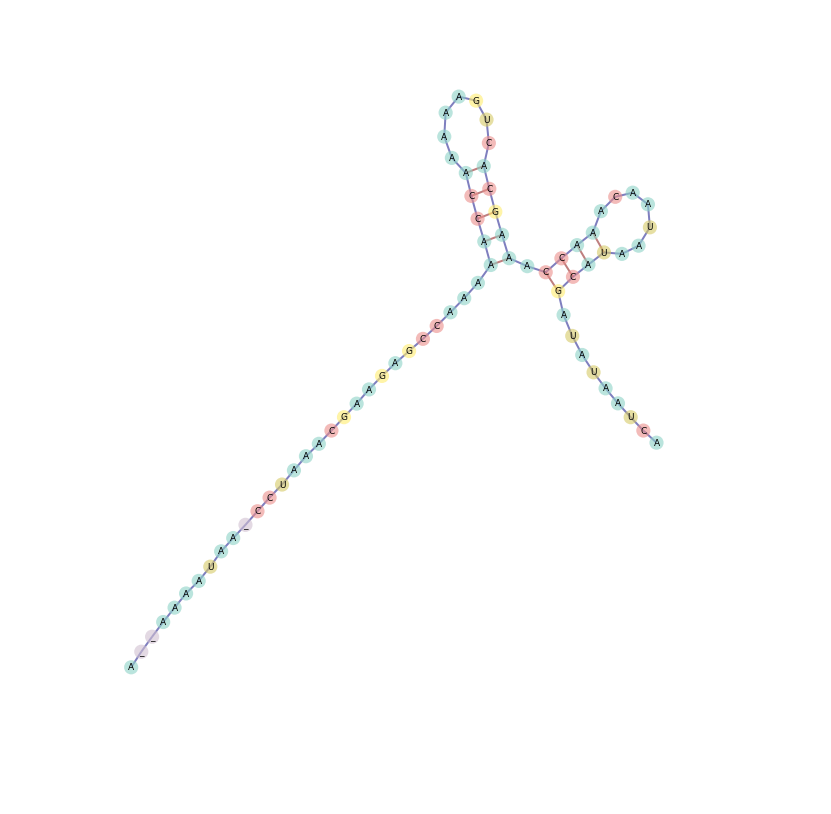

  _  _ ___  _____  __  __  _  __ _  _  _  _ _           ____  _____   _
GUUAAUGUAGCUUAAUAACAAAGCAAAGCACUGAAAAUGCUUAGAUGGAUAAUUGUAUCC-CAUAAAC--A
ACUUUUAUAGGAUAAUAGUAAUCCAUUGGUCUUAGGAACCAAAAACCUUGGUGCAAAUCCAAAUAAAAGUA


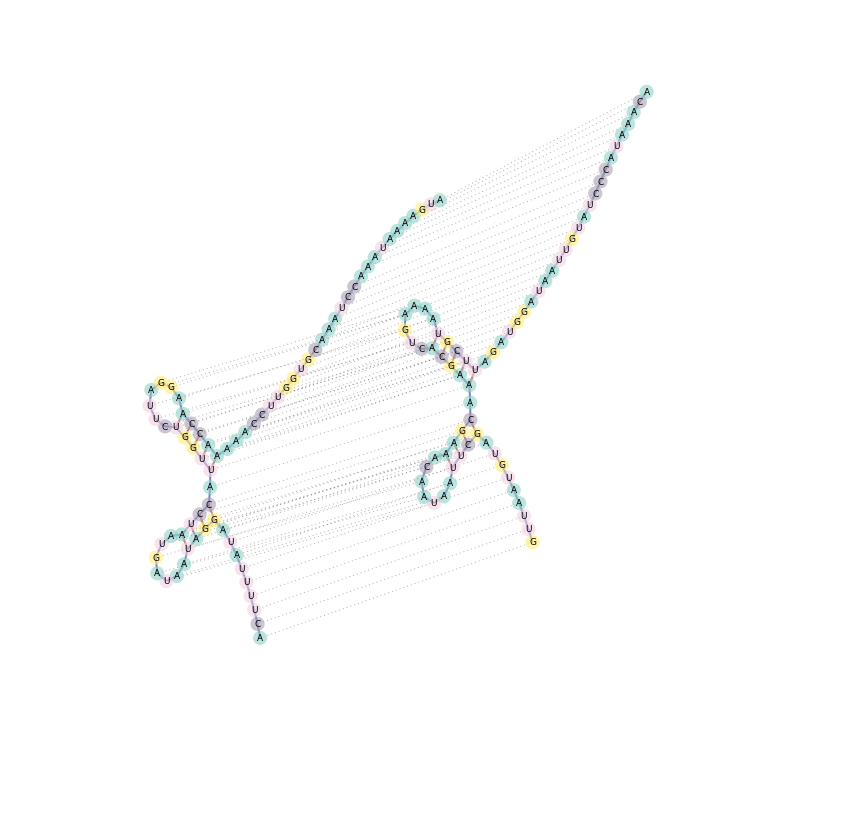

In [28]:
consensus, struct = fold_align(alignment_a, alignment_b)
seq_a, struct_a = project(alignment_a, struct)
print seq_a
print struct_a
graph_c_a = make_graph(seq_a, struct_a)
draw_RNA(graph_c_a)

seq_b, struct_b = project(alignment_b, struct)
print seq_b
print struct_b
graph_c_b = make_graph(seq_b, struct_b)
draw_RNA(graph_c_b)


graph_c = make_graph(consensus, struct)
draw_RNA(graph_c)


union_graph, alignment_c_a, alignment_c_b = join_graphs(graph_c_a, graph_c_b)

print_alignment(alignment_c_a, alignment_c_b)
plot([union_graph], opts=my_opt)

In [29]:
print_alignment(alignment_a, alignment_b)
print_alignment(alignment_c_a, alignment_c_b)

  _  _ ___  _____  __  __  _  __ _  _  _  _ _           ____  _____   _
GUUAAUGUAGCUUAAUAACAAAGCAAAGCACUGAAAAUGCUUAGAUGGAUAAUUGUAUCC-CAUAAAC--A
ACUUUUAUAGGAUAAUAGUAAUCCAUUGGUCUUAGGAACCAAAAACCUUGGUGCAAAUCCAAAUAAAAGUA
  _  _ ___  _____  __  __  _  __ _  _  _  _ _           ____  _____   _
GUUAAUGUAGCUUAAUAACAAAGCAAAGCACUGAAAAUGCUUAGAUGGAUAAUUGUAUCC-CAUAAAC--A
ACUUUUAUAGGAUAAUAGUAAUCCAUUGGUCUUAGGAACCAAAAACCUUGGUGCAAAUCCAAAUAAAAGUA


---